# Regression, Model Selection and DMD

##### Diego Alba, AMATh 563, 4/2020

### Abstract:

The goal of this assignment is to determine a mapping from the image space to the label space of the MNIST dataset with different solvers/algorithms and regularizations and evaluate how each method performs. Moreover, we will investigate which pixels are most characteristic for each digit. 

### Background

The MNIST dataset contains 28x28 pixel images of handwritten digits, 0-9. Each image is associated with its corresponding digit label, i.e., an integer 0-9. The dataset has already been split into train and test sets, with 60k and 10k images and labels, respectively. A visualization of the images and labels is provided in the Implementation and Results section. 

To determine the mapping between images and labels for each digit, we will use different solvers. Considering each image as vector of pixels such that the image space is described with a 60000x784 matrix, and the label space with a 60000x10 (where each label is now an orthogonal unit vector), we can propose a 784x10 mapping from images to labels. We will frame the problem of finding the best mapping as an optimization problem. The different methods we will use are the following:

- Least Squares: minimizing the squared Euclidean 2-norm, x st. min (b - A x)^2, where x is the mapping, A the images, and b the labels. Implemented through np.linalg.lstsq.
- Ridge: least squares with L2, or Ridge, regularization, x st. min (b - A x)^2 + x^2. Implemented through klearn.linear_model.Ridge.
- Lasso: least squares with L1, or Lasso, regularization, x st. min (b - A x)^2 + |x|. Implemented through klearn.linear_model.Lasso.
- Elastic Net: least squares with a mixture of L1 and L2 regularization, x st. min (b - A x)^2 + L|x| + (1-L)x^2, where L si the ratio of L1 regularization. Implemented through klearn.linear_model.ElasticNet.

The purpose of adding the regularization are twofold: to solve an ill-posed problem and to prevent overfitting. Where L1 makes the solution more sparse (most of the variables or weights will be 0), L2 makes all variables take small, non-zero values. The Elastic Net method tries to encompass the benefit of both regularizations. By promoting sparisty, the mapping will ideally be more interpretable.

In order to verify the validity of the model, we will employ k-fold cross validation. With this method, the test dataset will be split into k-folds and train solely in k-1 folds at a time, for a total of k times, changing which folds are used for training. During each iteration, the rest of the data is used for evaluating the model. By measuring the spread of the error, one is able to identify any data partition dependence bias, as well as to get a sense for how well the model will perform on new data.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from IPython.core.display import HTML
print("HTML Settings, don't know how to remove these two blocks")
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: center;
}
</style>
""")

HTML Settings, don't know how to remove these two blocks


In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
import numpy as np
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.preprocessing import OneHotEncoder as OHE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

### Implementation and Results

The fist thing we'll set up some settings for the Jupyter notebook and import all of the packages required to carry out the analysis and plotting.

Next, we will download the data. The MNIST can be downloaded from http://yann.lecun.com/exdb/mnist/ or directly imported from packages such as TensorFLow.

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

To understand what the data contains, we will display several images and their corresponding label.

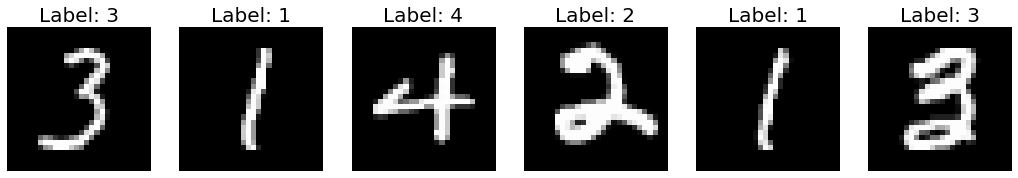

In [6]:
n = 6
a = np.random.randint(len(x_train), size=n)

plt.figure(figsize=(3*n,10))
for i,k in zip(range(n),a):
    plt.subplot(1,n,i+1)
    plt.imshow(x_train[k,:,:].squeeze(),'gray')
    plt.title('Label: ' + str(y_train[k]), fontsize=20)
    plt.axis('off')

Next, we will vectorize the dataset. This will allow us to use linear algebra to find the mapping between the pixel values and the digit label. For the images, we will reshape them so every row is an image with 28x28=784 pixel values. For the labels, we will perform a one-hot encoding, meaning every label will be converted from an integer to a binary vector. It could be intersting to compare the perfomance with tensor algebra, without having to reshaping the images.  

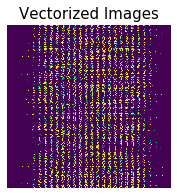

In [7]:
l = len(x_train[0,0,:])
A = np.reshape(x_train,(len(x_train),l**2))
Atest = np.reshape(x_test,(len(x_test),l**2))

ohe = OHE(sparse = False).fit(y_train.reshape(-1, 1))
B = ohe.transform(y_train.reshape(-1, 1))
Btest = ohe.transform(y_test.reshape(-1, 1))

plt.figure(figsize=(3,3))
plt.imshow(A[:l**2,:])
plt.title('Vectorized Images', fontsize=15)
plt.axis('off');

def plot_weights(w,title):
    if len(w.shape) == 2: 
        if w.shape[0] == 10: w = np.sum(w,0)
        elif w.shape[1] == 10: w = np.sum(w,1)
    fig = plt.figure(constrained_layout=True, figsize = (9,3))
    gs = GridSpec(1, 2, figure=fig)
        
    ax0 = plt.subplot(gs.new_subplotspec((0, 0), colspan=1))
    ca = ax0.imshow(np.reshape(w,(l,l)),'Spectral', vmin=-np.max(np.abs(w)),vmax=np.max(np.abs(w)))
    plt.colorbar(ca,location='left')
    ax0.get_yaxis().set_visible(False)
    ax0.get_xaxis().set_visible(False)
    ax0.set_title(title)


    ax2 = plt.subplot(gs.new_subplotspec((0, 1), colspan=1))
    ax2.bar(np.arange(l**2),np.sort(np.abs(w)))
    ax2.set_title('Absolute Value, Sorted')
    ax2.get_yaxis().set_visible(True)
    ax2.set_xlabel('pixels')

From the image above, it is clear that most of the image information is present at the center. Therefore, we expect the most important pixels to be in this location instead of the edges of the image.

Next, we will use the different algorithms previously described to determine the mapping between images and labels. Moreover, we will use 6-fold cross validation to verify our results are idependet of the data used for training. We report this as relative standard deviation.

Since we observe a very low RSD, most likely due to the simplicity and the class balance of the data, we go ahead and use the entire initial train split in the model. However, ridge regression does seem to depend on train split. 

We test the different models in the original 10k test split. To calculate the R^2 value, we take the index of the maxium value in the output vector as the correspoding digit label. Note we made the artibirary choice to report R^2, accuracy or recall can also be calculated.

In [8]:
x,res,rank,s = np.linalg.lstsq(A, B, rcond=None)
lst_r2 = np.round(r2_score(Btest,ohe.transform(np.argmax(np.matmul(Atest,x),axis=1).reshape(-1, 1))),3)

ridge = Ridge()
ridge.fit(A,B)
cv = cross_val_score(ridge,A,B, cv=6)
ridge_rsd = np.round(np.std(cv)/np.mean(cv)*100,3)
ridge_r2 = np.round(r2_score(Btest,ohe.transform(np.argmax(ridge.predict(Atest),axis=1).reshape(-1, 1))),3)

mix = ElasticNet(alpha = 1, l1_ratio = 1/9)
mix.fit(A,B)
cv = cross_val_score(mix,A,B, cv=6)
mix_rsd = np.round(np.std(cv)/np.mean(cv)*100,3)
mix_r2 = np.round(r2_score(Btest,ohe.transform(np.argmax(mix.predict(Atest),axis=1).reshape(-1, 1))),3)

lasso = Lasso()
lasso.fit(A,B)
true = np.copy(lasso.coef_)

cv = cross_val_score(lasso,A,B, cv=6)
lasso_rsd = np.round(np.std(cv)/np.mean(cv)*100,3)
lasso_r2 = np.round(r2_score(Btest,ohe.transform(np.argmax(lasso.predict(Atest),axis=1).reshape(-1, 1))),3)

In the following plots, we will display the mapping (weights for each method, averaged across digits) on the left, and the histogram of absolute vaules of the weights on the right. This will give us a sense of the importance of each pixel, as well as the spread of that importance across all pixels.

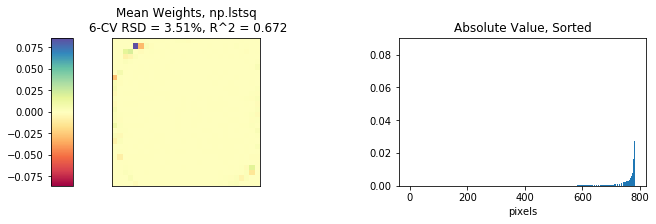

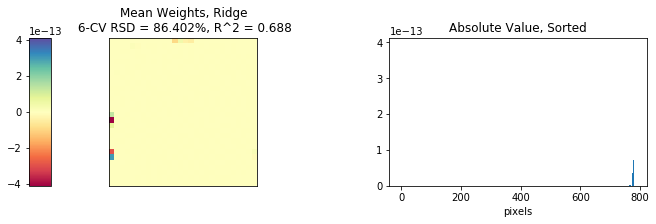

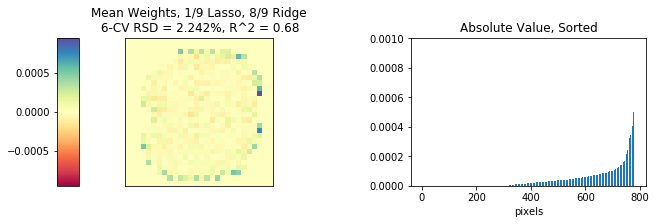

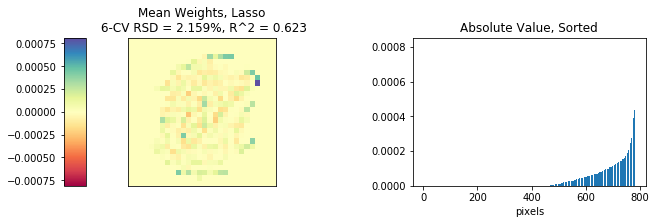

In [9]:
plot_weights(x,'Mean Weights, np.lstsq\n 6-CV RSD = 3.51%, R^2 = '+str(lst_r2))
plot_weights(ridge.coef_,'Mean Weights, Ridge\n 6-CV RSD = {}%, R^2 = {}'.format(ridge_rsd,ridge_r2))
plot_weights(mix.coef_,'Mean Weights, 1/9 Lasso, 8/9 Ridge\n 6-CV RSD = {}%, R^2 = {}'.format(mix_rsd,mix_r2))
plot_weights(true,'Mean Weights, Lasso\n 6-CV RSD = {}%, R^2 = {}'.format(lasso_rsd,lasso_r2))

From these results, it is clear Lasso regularization increases sparsity in the mapping, highlighting the most importnat pixels. Note the contrast in magnitude between Ridge and Lasso weights. We can go one step further and break down the mapping for each digit.

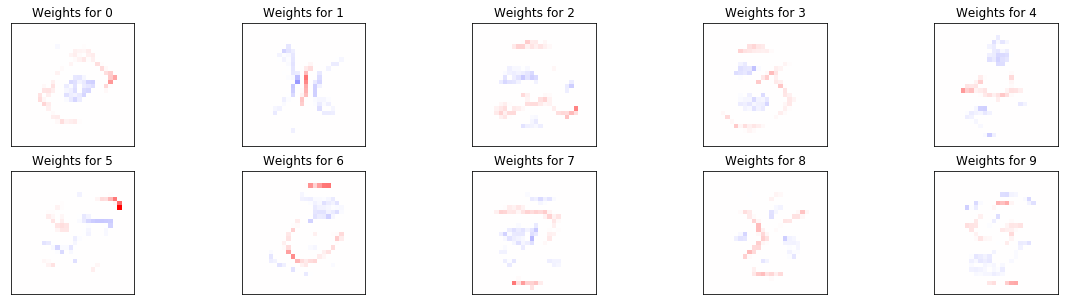

In [10]:
plt.figure(figsize=(20,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(true[i].reshape(28,28),'bwr',vmin=-np.max(np.abs(true)),vmax=np.max(np.abs(true)))
    plt.title('Weights for '+str(i))
    plt.gca().set_xticks(())
    plt.gca().set_yticks(())

Breaking down the mapping for each digit really lets us explore their inherit definition, i.e., what makes a 3 a 3 and not an 8. In some cases this is really clear, such as 0, 3, or 7, and in other not so much (5, 9). This could be both because these digits are intrinsically harder to distinguish, or because there is an imbalance, either in terms of quantity or quality, in the dataset.<div class="pagebreak"></div>

Next, we will explore what happens when we only use a small percentage of the most important pixel weights.

In [11]:
coef = np.sum(true,0)
pixels = np.argsort(-1*np.abs(coef))
top = pixels[:int(np.round(l**2*0.05))]

loads = np.zeros(true.shape)
loads[:,top] = true[:,top]

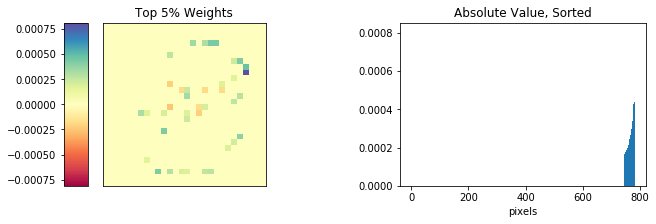

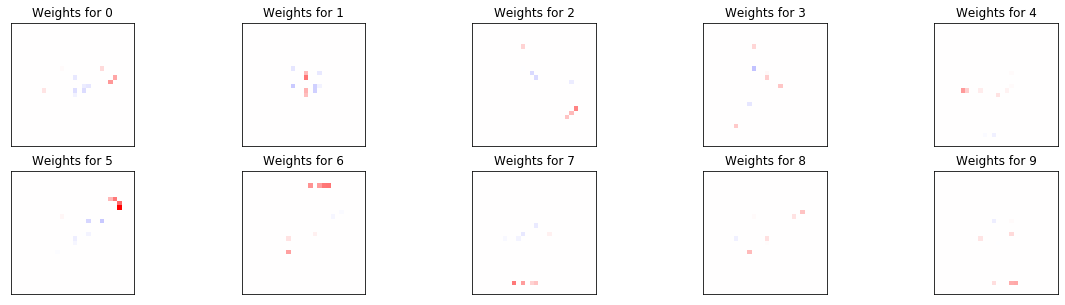

In [12]:
plot_weights(loads, 'Top 5% Weights')
plt.figure(figsize=(20,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(loads[i].reshape(28,28),'bwr',vmin=-np.max(np.abs(loads)),vmax=np.max(np.abs(loads)))
    plt.title('Weights for '+str(i))
    plt.gca().set_xticks(())
    plt.gca().set_yticks(())

The above graphs show which pixels have been seleceted based on our criteria, and we can already tell that distinguishing between digits with such few weights will be extremely hard.

In this next block of code we will calculate the test error and try to visualize the impact of reducing the number of weights on our predictions.

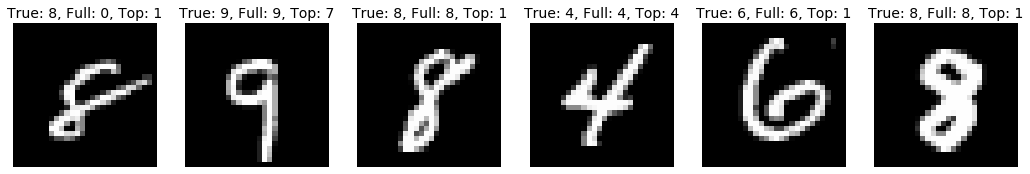

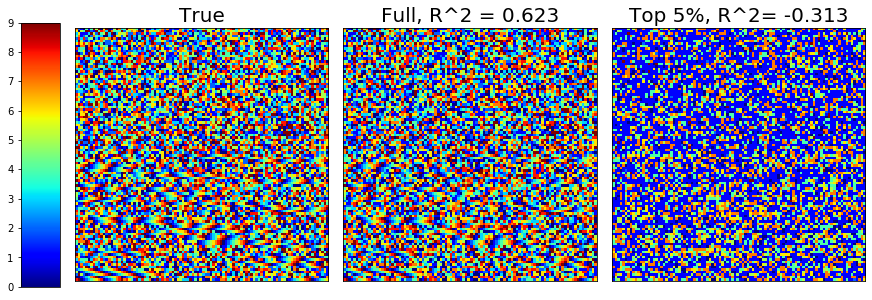

In [13]:
lasso.coef_ = true
Bhat_full = lasso.predict(Atest)
r2_full = np.round(r2_score(Btest,ohe.transform(np.argmax(lasso.predict(Atest),axis=1).reshape(-1, 1))),3)
yhat_full = np.argmax(Bhat_full,1)

lasso.coef_ = loads
Bhat_top = lasso.predict(Atest)
r2_top = np.round(r2_score(Btest,ohe.transform(np.argmax(lasso.predict(Atest),axis=1).reshape(-1, 1))),3)
yhat_top = np.argmax(Bhat_top,1)

n = 6
a = np.random.randint(len(x_test), size=n)

plt.figure(figsize=(3*n,10))
for i,k in zip(range(n),a):
    plt.subplot(1,n,i+1)
    plt.imshow(x_test[k,:,:].squeeze(),'gray')
    plt.title('True: ' + str(y_test[k])+', Full: ' + str(yhat_full[k])+', Top: ' + str(yhat_top[k]), fontsize=14)
    plt.axis('off')

fig = plt.figure(constrained_layout=True, figsize = (12,4))
gs = GridSpec(1, 3, figure=fig)
y = [y_test,yhat_full,yhat_top]
titles = ['True','Full, R^2 = ', 'Top 5%, R^2= ']
r2 = ['',str(r2_full),str(r2_top)]

for i in range(3):
    ax0 = plt.subplot(gs.new_subplotspec((0, i), colspan=1))
    ca = ax0.imshow(y[i].reshape(100,100),'jet')
    if i == 0: plt.colorbar(ca,location='left')
    ax0.get_yaxis().set_visible(False)
    ax0.get_xaxis().set_visible(False)
    ax0.set_title(titles[i]+r2[i], fontsize = 20)

Here, we can see how different the predictions, and hence the error (measured in R^2), are. In the top row we have a sample of predictions, and what each method, Full and Top 5% Weights, predicted. On the bottom row, we show all of the predictions for the test data, and the error for each method. We can see using only 5% of the weight heavily shifts predictions to the lower digits.

Next, we can ask the question of how accurate we can be with as few pixels as possible. For this, we will simply increase the percent of weights used and calculate the error on the test data at each iteration.

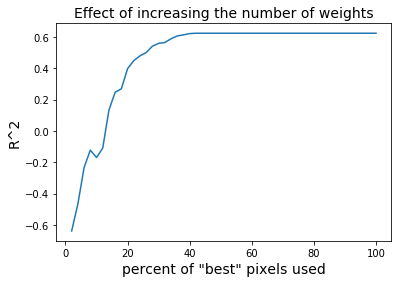

In [14]:
allr2 = []
percent = []
for i in range(50):
    p = (100-2*i)/100
    top = pixels[:int(np.round(l**2*p))]

    loads = np.zeros(true.shape)
    loads[:,top] = true[:,top]
    lasso.coef_ = loads

    allr2.append(np.round(r2_score(Btest,ohe.transform(np.argmax(lasso.predict(Atest),axis=1).reshape(-1, 1))),5))
    percent.append(p*100)

plt.plot(percent,allr2)
plt.xlabel('percent of "best" pixels used', fontsize = 14)
plt.ylabel('R^2', fontsize = 14)
plt.title('Effect of increasing the number of weights',fontsize = 14);

From this graph we can see that our accuracy increases rapidly as we increase the number of weights, but only during the first 40 percent points, after which the error stays constant. We suspect this is highly correlated with the number of none zero weights determined through the Lasso regularization.

Lastly, we will investigate we will investigate which pixels are most characteristic for each digit. We can approach this from several angles. First we'll try doing least squares regression solely on one digit at a time. The most important pixels for each digit are show below.

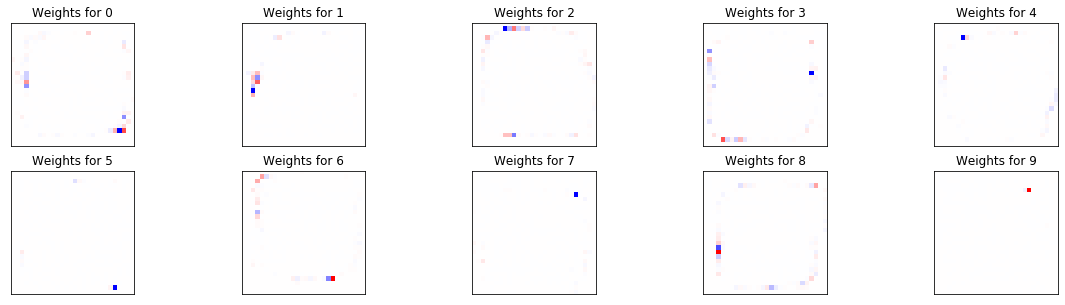

In [15]:
plt.figure(figsize=(20,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    x,res,rank,s = np.linalg.lstsq(A[y_train==i],B[y_train==i], rcond=None)
    plt.imshow(x.T[i].reshape(28,28),'bwr',vmin=-np.max(np.abs(x)),vmax=np.max(np.abs(x)))
    plt.title('Weights for '+str(i))
    plt.gca().set_xticks(())
    plt.gca().set_yticks(())

We can see this method is not very informative, mainly because we did not promote sparsity.

Another option is to analyze the weights from the Lasso regression done earlier,since this weights determine the best mapping such that each digit can be identified.

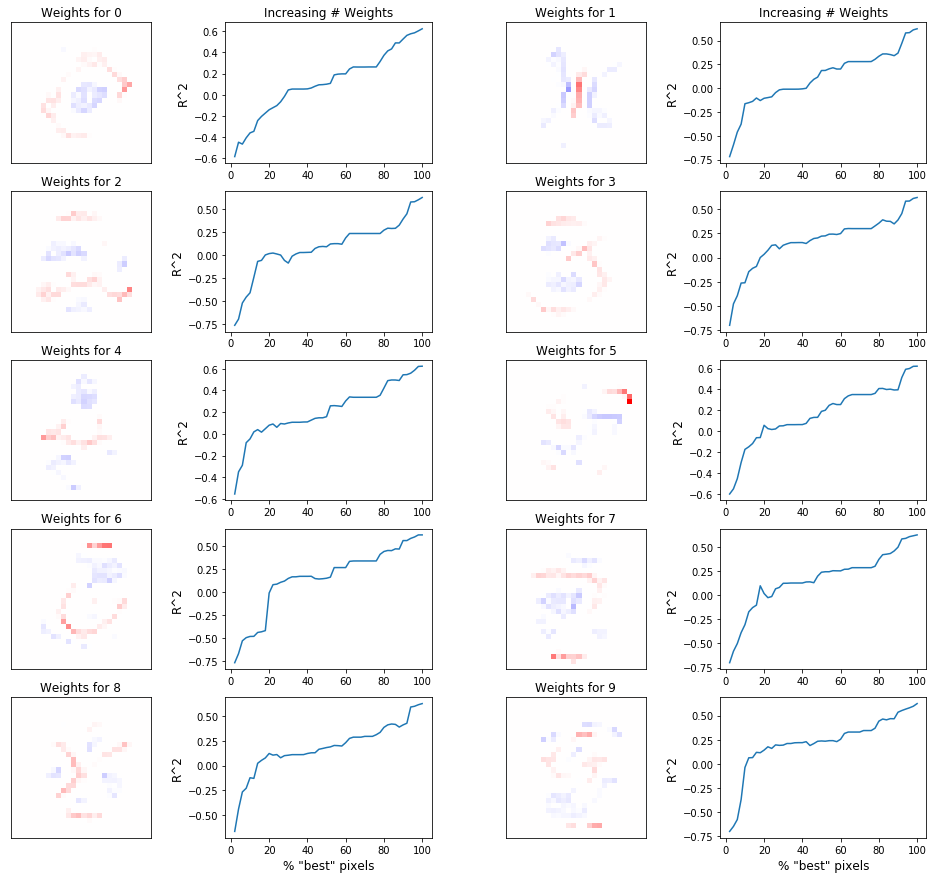

In [61]:
plt.figure(figsize=(17,15))
c=1
for k in range(10):
    allr2 = []
    percent = []
    for i in range(50):
        p = (100-2*i)/100
        
        pixels = np.argsort(-1*np.abs(true[k,:]))
        top = pixels[:int(np.round(l**2*p))]

        loads = np.zeros(true.shape)
        loads[:,top] = true[:,top]
        lasso.coef_ = loads

        allr2.append(np.round(r2_score(Btest,ohe.transform(np.argmax(lasso.predict(Atest),axis=1).reshape(-1, 1))),5))
        percent.append(p*100)
        
    plt.subplot(5,4,c)
    plt.imshow(true[k].reshape(28,28),'bwr',vmin=-np.max(np.abs(true)),vmax=np.max(np.abs(true)))
    plt.title('Weights for '+str(k))
    plt.gca().set_xticks(())
    plt.gca().set_yticks(())
    c = c+1
    
    plt.subplot(5,4,c)
    plt.plot(percent,allr2)
    if c > 17: plt.xlabel('% "best" pixels', fontsize = 12)
    plt.ylabel('R^2', fontsize = 12)
    if c < 5: plt.title('Increasing # Weights',fontsize = 12);
    c = c+1


We can observe every digit, or the mapping for each digit, is different, and not all pixels are weighted the same. For instance, the most important digits to identify a 3 carry more information than those to identify a 0.

### Conlcusion

We have shown how to use different methods for solving optimization problems. Particularly, we have seen that the algorithm and regularization used heavily determine the solution. For instances in which we are trying to gain insight into the model and the underlaying variables, promoting sparsity through the L1-norm turns out to be very valuable.

### Appendix

The full Jupyter Notebook containing the report and the code used can be found at https://github.com/DIEGOA363/ISCS